<a href="https://colab.research.google.com/github/dingowhiz/Data_Analytics_ML/blob/main/mayo_stroke_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

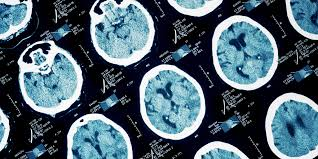
#  Mayo Clinic Image Classification of Stroke Blood Clot Origin   

## Predict the origin of blood clot in ischemic stroke patients using Machine Learning multiclass classification models
@author: Russell Tang, Dominador Ramos Jr



## Objective

* Stroke remains the second-leading cause of death worldwide. Each year in the United States, over 700,000 individuals experience an ischemic stroke caused by a blood clot blocking an artery to the brain. A second stroke (23% of total events are recurrent) worsens the chances of the patient’s survival. However, subsequent strokes may be mitigated if physicians can determine stroke etiology, which influences the therapeutic management following stroke events. 
* The objective of this project is to use Machine Learning model/s to predict the presence and origin of either one of the two major acute ischemic stroke (AIS) etiology subtypes: cardiac and large artery atherosclerosis by analysing the digital pathology slides, Whole Slide Images (WSI).
* Tasks include building an image processing pipeline with image loading, segmentation, augmentation and transformation of 724 WSI images and building of a deep learning neural network model https://news.mayocliniclabs.com/2019/10/16/introducing-whole-slide-imaging-to-pathways/

The dataset comprises over a thousand high-resolution whole-slide digital pathology images. Each slide depicts a blood clot from a patient that had experienced an acute ischemic stroke.

The slides comprising the training and test sets depict clots with an etiology (that is, origin) known to be either CE (Cardioembolic) or LAA (Large Artery Atherosclerosis). We include a set of supplemental slides with a either an unknown etiology or an etiology other than CE or LAA.

Data source consists of four datasets in csv format:-
* train.csv (754 images)
* test.csv (4 images)
* other.csv (396 images)

The expected deliverable of this project is a sample_submission.csv file with the result of the predicted probability values of label CE and LAA:- paient_id, CE, LAA.

This notebook serves as a model for data validation, it starts with image loading, image segmentation, pretrained model loading, model building and training, model validation, model scoring and evaluation.     


---



# Track Datasets

* Given datasets :- train.csv
* **Characteristics or dependent variables:-** image_id, center_id, patient_id, image_num
* **Target feature:-** label CE, LAA



### Import Python dependencies and load dataset 

In [2]:
pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 8.0 MB/s 


In [105]:
pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import sys
import math, time, random, datetime
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,64).__str__()

# Data Manipulation
import numpy as np
import pandas as pd
from numpy import vstack
from numpy import hstack
from pandas.api.types import is_numeric_dtype
import datetime 
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


import sklearn
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
import joblib
from joblib import dump, load

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use('seaborn-whitegrid')

# Preprocessing

import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Machine learning
import tensorflow as tf
import segmentation_models as sm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.models import Model
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D, Dense, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Flatten
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)

# Let's ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [107]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [108]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [109]:
!chmod 600 ~/.kaggle/kaggle.json

In [111]:
!kaggle competitions download -c mayo-clinic-strip-ai -f train.csv



  0% 0.00/17.5k [00:00<?, ?B/s]
100% 17.5k/17.5k [00:00<00:00, 1.55MB/s]


In [5]:
# load dataset                              

df_train = pd.read_csv('/content/drive/MyDrive/Mayo/train.csv')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print('Shape of training dataset: ', df_train.shape)
print(df_train.info())
display(df_train.head(3))
print('\n')

Shape of training dataset:  (754, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    754 non-null    object
 1   center_id   754 non-null    int64 
 2   patient_id  754 non-null    object
 3   image_num   754 non-null    int64 
 4   label       754 non-null    object
dtypes: int64(2), object(3)
memory usage: 29.6+ KB
None


,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA


Total no. of patients : 632


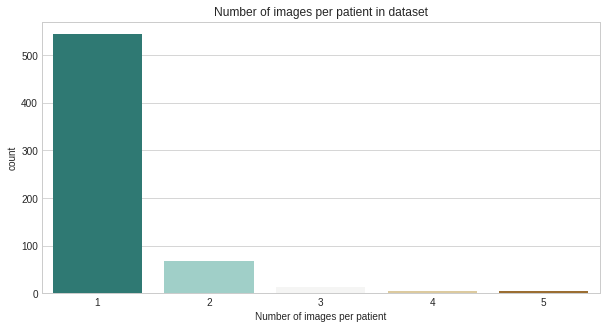

In [6]:
print('Total no. of patients :', df_train.patient_id.nunique())
plt.figure(figsize=(10,5))
sns.countplot(df_train.groupby("patient_id").image_num.size(), palette="BrBG_r")
plt.xlabel("Number of images per patient")
plt.title("Number of images per patient in dataset");

CE     0.725464
LAA    0.274536
Name: label, dtype: float64

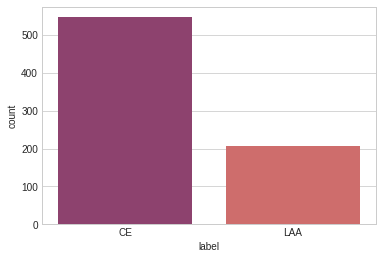

In [7]:

sns.countplot(df_train.label, palette="flare_r")
df_train.label.value_counts() / df_train.shape[0]

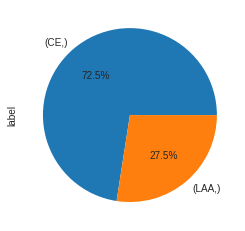

In [8]:
_=df_train[['label']].value_counts().plot.pie(autopct='%1.1f%%', ylabel='label')

A quick look at the train dataframe does not indicate any blank or null fields in the train dataset but the dataset is imbalanced with the occurence of CE is about 2.6 times that of LAA. 

In [9]:
ce_list = os.listdir('/content/drive/MyDrive/Mayo/train/CE')
laa_list = os.listdir('/content/drive/MyDrive/Mayo/train/LAA')
print(len(ce_list), ',', len(laa_list))
ce_list = [x[:8] for x in ce_list]
laa_list = [x[:8] for x in laa_list]
ce_list


20 , 10


['112b6e_0',
 '12c8c9_0',
 '045eb0_0',
 '1295bb_0',
 '008e5c_0',
 '026c97_0',
 '032f10_0',
 '0372b0_0',
 '09644e_4',
 '04439c_0',
 '03e6b7_0',
 '0aaeb3_0',
 '0aff58_0',
 '0b7cc8_0',
 '0c60b8_0',
 '0cc0bc_0',
 '0ed87f_0',
 '0ed87f_1',
 '0ff890_0',
 '0ff6fc_0']

In [74]:
X_ce = df_train[df_train['image_id'].isin(ce_list)]
X_laa = df_train[df_train['image_id'].isin(laa_list)]
X_train = pd.concat([X_ce, X_laa])
X_train.head()

,image_id,center_id,patient_id,image_num,label
1,008e5c_0,11,008e5c,0,CE
4,026c97_0,4,026c97,0,CE
7,032f10_0,7,032f10,0,CE
8,0372b0_0,7,0372b0,0,CE
11,03e6b7_0,7,03e6b7,0,CE


In [75]:
# shuffle training sample datasets
X_train = X_train.sample(frac=1)
X_train.head

<bound method NDFrame.head of      image_id  center_id patient_id  image_num label
65   12c8c9_0          9     12c8c9          0    CE
38   0b7cc8_0          4     0b7cc8          0    CE
70   15de51_0          4     15de51          0   LAA
59   0ff890_0          7     0ff890          0    CE
13   04439c_0         11     04439c          0    CE
52   0ed87f_0          2     0ed87f          0    CE
42   0c60b8_0          1     0c60b8          0    CE
53   0ed87f_1          2     0ed87f          1    CE
60   112b6e_0         11     112b6e          0    CE
88   1f018f_0          9     1f018f          0   LAA
29   09644e_4         10     09644e          4    CE
109  244aeb_0          4     244aeb          0   LAA
64   1295bb_0         11     1295bb          0    CE
43   0cc0bc_0          4     0cc0bc          0    CE
34   0aff58_0         10     0aff58          0    CE
127  2a25b9_0          2     2a25b9          0   LAA
7    032f10_0          7     032f10          0    CE
110  244aeb_1   

In [12]:
# remove background image
def remove_bkgd(img, mask, threshold=0.990):
  for i in reversed(range(img.shape[1])):      #<--- remove columns
    if (np.sum(mask[:, i]) / float(mask.shape[0])) > threshold:
      img = np.delete(img, i, 1)

  for i in reversed(range(img.shape[0])):      #<--- remove rows
    if (np.sum(mask[i, :]) / float(mask.shape[1])) > threshold:
      img = np.delete(img, i, 0)
  return img

In [13]:
# make mask
def mask_filter(img, val=255):
  masks = [None]*3
  for color in range(3):
    masks[color] = img[..., color] >= np.median(img[:, :, color]) - 5
  mask = np.logical_and(*masks)
  img[mask, :] = val
  return img, mask

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

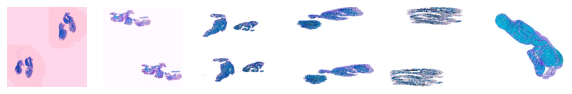

In [76]:
# file_name = "/content/"
# with ZipFile(file_name,'r') as zip:
#   zip.extractall()
#   print('Done')
#   os.chdir('/content/drive/MyDrive/Mayo/')

X = []
y = []
os.chdir('/content/drive/MyDrive/Mayo/train/CE')
for i in tqdm(os.listdir()):
      img = cv2.imread(i)   
      img = cv2.resize(img,(224,224))      #<=== resize image to 224x224 pixels
      #img, mask = mask_filter(np.array(img))
      #img = remove_bkgd(img, mask)
      X.append(img)
      #y.append((i['label']))
      #print(i[0:1])
os.chdir('/content/drive/MyDrive/Mayo/train/LAA')
for i in tqdm(os.listdir()):
      img = cv2.imread(i)   
      img = cv2.resize(img,(224,224))
      #img, mask = mask_filter(np.array(img))
      #img = remove_bkgd(img, mask)
      X.append(img)
#for i in range(1,99):
      #y.append('label')
#print(y)

plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()


In [77]:
y = X_train['label']
y=y.replace('CE', 0)
y=y.replace('LAA', 1).reset_index(drop=True)
y

0     0
1     0
2     1
3     0
4     0
5     0
6     0
7     0
8     0
9     1
10    0
11    1
12    0
13    0
14    0
15    1
16    0
17    1
18    0
19    0
20    0
21    0
22    0
23    0
24    1
25    1
26    1
27    1
28    1
29    0
Name: label, dtype: int64

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape, len(X_train))
print ("Shape of an image in X_test: ", X_test[0].shape)
# le = preprocessing.LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.fit_transform(y_test)
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train = X_train.reshape(X_train.shape[0], 224, 224,3).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 224, 224,3).astype('float32')

X_train = X_train/224
X_test = X_test/224
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

# y_train = np.array(y_train)
# X_train = np.array(X_train)
# y_test = np.array(y_test)
# X_test = np.array(X_test)
print("X_train Shape: ", X_train.shape) 
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape) 
print("y_test Shape: ", y_test.shape)

Shape of an image in X_train:  (224, 224, 3) 20
Shape of an image in X_test:  (224, 224, 3)
X_train Shape:  (20, 224, 224, 3)
X_test Shape:  (10, 224, 224, 3)
y_train Shape:  (20, 2)
y_test Shape:  (10, 2)


In [95]:
img_temp, mask = mask_filter(np.array(img))
img_temp = remove_bkgd(img, mask)

In [96]:
img_temp.shape

(86, 126, 3)

In [97]:
BACKBONE1 ='resnet50'
BACKBONE2 ='efficientnetb2'
BACKBONE3 ='inceptionv3'
BACKBONE4 ='vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE1)
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [98]:
img_rows, img_cols = 224, 224 

sm.set_framework('tf.keras')
sm.framework()

model = sm.Unet(BACKBONE1, encoder_weights='imagenet', encoder_freeze=True)
for layer in model.layers:
    layer.trainable = False
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 BatchNormalization False
2 ZeroPadding2D False
3 Conv2D False
4 BatchNormalization False
5 Activation False
6 ZeroPadding2D False
7 MaxPooling2D False
8 BatchNormalization False
9 Activation False
10 Conv2D False
11 BatchNormalization False
12 Activation False
13 ZeroPadding2D False
14 Conv2D False
15 BatchNormalization False
16 Activation False
17 Conv2D False
18 Conv2D False
19 Add False
20 BatchNormalization False
21 Activation False
22 Conv2D False
23 BatchNormalization False
24 Activation False
25 ZeroPadding2D False
26 Conv2D False
27 BatchNormalization False
28 Activation False
29 Conv2D False
30 Add False
31 BatchNormalization False
32 Activation False
33 Conv2D False
34 BatchNormalization False
35 Activation False
36 ZeroPadding2D False
37 Conv2D False
38 BatchNormalization False
39 Activation False
40 Conv2D False
41 Add False
42 BatchNormalization False
43 Activation False
44 Conv2D False
45 BatchNormalization False
46 Activation False
47 ZeroPadding2D F

In [99]:
# Transfer learning, import pretrained VGG16 model
# from keras.applications import vgg16

# vgg = vgg16.VGG16(weights = 'imagenet', 
#                  include_top = False, 
#                  input_shape = (img_rows, img_cols, 3))

# freeze layers
# Layers are set to trainable as True by default
# for layer in vgg.layers:
#     layer.trainable = False
    
# for (i,layer) in enumerate(vgg.layers):
#     print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

def lw(bottom_model, num_classes):
    #"""creates the top or head of the model that will be 
    #placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model 

num_classes = 2

# FC_Head = lw(vgg, num_classes)
FC_Head = lw(model, num_classes)

# model = Model(inputs = vgg.input, outputs = FC_Head)
model = Model(inputs = model.input, outputs = FC_Head)

print(model.summary())
print('Total no. of layers : ',len(model.layers))



Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_328 (ZeroPaddin  (None, None, None,   0          ['bn_data[0][0]']                
 g2D)                           3)                                                         

Epoch 1/20
1/1 [==============================] - 5s 5s/step - loss: 0.5005 - accuracy: 0.8000 - val_loss: 1.0640 - val_accuracy: 0.4000
Epoch 2/20
1/1 [==============================] - 0s 189ms/step - loss: 0.5005 - accuracy: 0.8000 - val_loss: 1.0562 - val_accuracy: 0.4000
Epoch 3/20
1/1 [==============================] - 0s 185ms/step - loss: 0.5005 - accuracy: 0.8000 - val_loss: 1.0495 - val_accuracy: 0.4000
Epoch 4/20
1/1 [==============================] - 0s 182ms/step - loss: 0.5005 - accuracy: 0.8000 - val_loss: 1.0493 - val_accuracy: 0.4000
Epoch 5/20
1/1 [==============================] - 0s 183ms/step - loss: 0.5005 - accuracy: 0.8000 - val_loss: 1.0531 - val_accuracy: 0.4000
Epoch 6/20
1/1 [==============================] - 0s 189ms/step - loss: 0.5005 - accuracy: 0.8000 - val_loss: 1.0577 - val_accuracy: 0.4000
Epoch 7/20
1/1 [==============================] - 0s 188ms/step - loss: 0.5005 - accuracy: 0.8000 - val_loss: 1.0604 - val_accuracy: 0.4000
Epoch 8/20
1/1 [=======

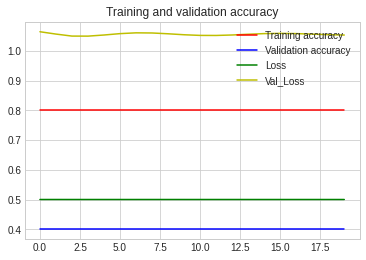

<Figure size 432x288 with 0 Axes>

In [103]:
# Build model
model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name="Adam"), loss = 'categorical_crossentropy',metrics = ['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=20, 
                    validation_data=(X_test,y_test),
                    verbose = 1,
                    initial_epoch=0)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.plot(epochs, loss, 'g', label='Loss')
plt.plot(epochs, val_loss, 'y', label='Val_Loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [36]:
y_predict = model.predict(X_test)

In [37]:
from sklearn.metrics import log_loss
log_loss(y_test, y_predict)

0.7111825406551361

In [ ]:
T = []
os.chdir('/content/drive/MyDrive/Mayo/test(unseen)')
for i in tqdm(os.listdir()):
      img = cv2.imread(i)   
      img = cv2.resize(img,(224,224))      #<=== resize image to 224x224 pixels
      #img, mask = mask_filter(np.array(img))
      #img = remove_bkgd(img, mask)
      T.append(img)

  0%|          | 0/6 [00:00<?, ?it/s]

error: ignored

In [ ]:
class WeightedMultiClassLogarithmicLoss():
    def __init__(self, epsilon=10e-15, weights=np.ones(2, dtype='float64'), class_proportions=np.ones(2, dtype='float64')):
        self.epsilon = epsilon
        self.weights = weights
        self.class_proportions = class_proportions
        #super().__init__()
    
    def call(self, y_true, y_pred):
        print(self.weights)
        print(self.class_proportions)
        print(self.epsilon)
        # probability 𝑝 is replaced with epsilon to avoid extremes of the log function
        y_pred_clipped = k.clip(y_pred, self.epsilon, 1-self.epsilon)
        # ground-truth labels are weighted
        y_true_weighted = (y_true * self.weights)/self.class_proportions
        # compute the log loss
        loss = -1*( k.sum(y_true_weighted * k.log(y_pred_clipped)) / k.sum(self.weights) )
        return loss

In [ ]:
# define the logloss function
weights = np.ones(2, dtype='float64')
weights[0] = 0.5
weights[1] = 0.5
class_counts = X_train.groupby('label')['image_id'].count().values 
class_proportions = class_counts/np.max(class_counts)
k.set_floatx('float64')
log_loss = WeightedMultiClassLogarithmicLoss(epsilon=10e-15, weights=weights, class_proportions=class_proportions)

AttributeError: ignored

# The End

In [ ]:
#import pyvips
from openslide import open_slide
import openslide
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

#Load the slide file (svs) into an object.
slide = open_slide("images/whole_slide_image.svs")

slide_props = slide.properties
print(slide_props)

print("Vendor is:", slide_props['openslide.vendor'])
print("Pixel size of X in um is:", slide_props['openslide.mpp-x'])
print("Pixel size of Y in um is:", slide_props['openslide.mpp-y'])

#Objective used to capture the image
objective = float(slide.properties[openslide.PROPERTY_NAME_OBJECTIVE_POWER])
print("The objective power is: ", objective)

# get slide dimensions for the level 0 - max resolution level
slide_dims = slide.dimensions
print(slide_dims)

#Get a thumbnail of the image and visualize
slide_thumb_600 = slide.get_thumbnail(size=(600, 600))
slide_thumb_600.show()

#Convert thumbnail to numpy array
slide_thumb_600_np = np.array(slide_thumb_600)
plt.figure(figsize=(8,8))
plt.imshow(slide_thumb_600_np)    


#Get slide dims at each level. Remember that whole slide images store information
#as pyramid at various levels
dims = slide.level_dimensions

num_levels = len(dims)
print("Number of levels in this image are:", num_levels)

print("Dimensions of various levels in this image are:", dims)

#By how much are levels downsampled from the original image?
factors = slide.level_downsamples
print("Each level is downsampled by an amount of: ", factors)

#Copy an image from a level
level3_dim = dims[2]
#Give pixel coordinates (top left pixel in the original large image)
#Also give the level number (for level 3 we are providing a valueof 2)
#Size of your output image
#Remember that the output would be a RGBA image (Not, RGB)
level3_img = slide.read_region((0,0), 2, level3_dim) #Pillow object, mode=RGBA

#Convert the image to RGB
level3_img_RGB = level3_img.convert('RGB')
level3_img_RGB.show()

#Convert the image into numpy array for processing
level3_img_np = np.array(level3_img_RGB)
plt.imshow(level3_img_np)


#Return the best level for displaying the given downsample.
SCALE_FACTOR = 32
best_level = slide.get_best_level_for_downsample(SCALE_FACTOR)
#Here it returns the best level to be 2 (third level)
#If you change the scale factor to 2, it will suggest the best level to be 0 (our 1st level)
#################################

#Generating tiles for deep learning training or other processing purposes
#We can use read_region function and slide over the large image to extract tiles
#but an easier approach would be to use DeepZoom based generator.
# https://openslide.org/api/python/

from openslide.deepzoom import DeepZoomGenerator

#Generate object for tiles using the DeepZoomGenerator
tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
#Here, we have divided our svs into tiles of size 256 with no overlap. 

#The tiles object also contains data at many levels. 
#To check the number of levels
print("The number of levels in the tiles object are: ", tiles.level_count)

print("The dimensions of data in each level are: ", tiles.level_dimensions)

#Total number of tiles in the tiles object
print("Total number of tiles = : ", tiles.tile_count)

#How many tiles at a specific level?
level_num = 11
print("Tiles shape at level ", level_num, " is: ", tiles.level_tiles[level_num])
print("This means there are ", tiles.level_tiles[level_num][0]*tiles.level_tiles[level_num][1], " total tiles in this level")

#Dimensions of the tile (tile size) for a specific tile from a specific layer
tile_dims = tiles.get_tile_dimensions(11, (3,4)) #Provide deep zoom level and address (column, row)


#Tile count at the highest resolution level (level 16 in our tiles)
tile_count_in_large_image = tiles.level_tiles[16] #126 x 151 (32001/256 = 126 with no overlap pixels)
#Check tile size for some random tile
tile_dims = tiles.get_tile_dimensions(16, (120,140))
#Last tiles may not have full 256x256 dimensions as our large image is not exactly divisible by 256
tile_dims = tiles.get_tile_dimensions(16, (125,150))


single_tile = tiles.get_tile(16, (62, 70)) #Provide deep zoom level and address (column, row)
single_tile_RGB = single_tile.convert('RGB')
single_tile_RGB.show()

###### Saving each tile to local directory
cols, rows = tiles.level_tiles[16]

import os
tile_dir = "images/saved_tiles/original_tiles/"
for row in range(rows):
    for col in range(cols):
        tile_name = os.path.join(tile_dir, '%d_%d' % (col, row))
        print("Now saving tile with title: ", tile_name)
        temp_tile = tiles.get_tile(16, (col, row))
        temp_tile_RGB = temp_tile.convert('RGB')
        temp_tile_np = np.array(temp_tile_RGB)
        plt.imsave(tile_name + ".png", temp_tile_np)
        


In [ ]:

import numpy as np
import cv2
from matplotlib import pyplot as plt

############### INPUT RGB IMAGE #######################
#Using opencv to read images may bemore robust compared to using skimage
#but need to remember to convert BGR to RGB.
#Also, convert to float later on and normalize to between 0 and 1.

#Image downloaded from:
#https://pbs.twimg.com/media/C1MkrgQWQAASbdz.jpg
# img=cv2.imread('images/HnE_Image.jpg', 1)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Io = 240 # Transmitted light intensity, Normalizing factor for image intensities
# alpha = 1  #As recommend in the paper. tolerance for the pseudo-min and pseudo-max (default: 1)
# beta = 0.15 #As recommended in the paper. OD threshold for transparent pixels (default: 0.15)


def norm_HnE(img, Io=240, alpha=1, beta=0.15):


    ######## Step 1: Convert RGB to OD ###################
    ## reference H&E OD matrix.
    #Can be updated if you know the best values for your image. 
    #Otherwise use the following default values. 
    #Read the above referenced papers on this topic. 
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
    ### reference maximum stain concentrations for H&E
    maxCRef = np.array([1.9705, 1.0308])
    
    
    # extract the height, width and num of channels of image
    h, w, c = img.shape
    
    # reshape image to multiple rows and 3 columns.
    #Num of rows depends on the image size (wxh)
    img = img.reshape((-1,3))
    
    # calculate optical density
    # OD = −log10(I)  
    #OD = -np.log10(img+0.004)  #Use this when reading images with skimage
    #Adding 0.004 just to avoid log of zero. 
    
    OD = -np.log10((img.astype(np.float)+1)/Io) #Use this for opencv imread
    #Add 1 in case any pixels in the image have a value of 0 (log 0 is indeterminate)
    
    
    ############ Step 2: Remove data with OD intensity less than β ############
    # remove transparent pixels (clear region with no tissue)
    ODhat = OD[~np.any(OD < beta, axis=1)] #Returns an array where OD values are above beta
    #Check by printing ODhat.min()
    
    ############# Step 3: Calculate SVD on the OD tuples ######################
    #Estimate covariance matrix of ODhat (transposed)
    # and then compute eigen values & eigenvectors.
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
    
    
    ######## Step 4: Create plane from the SVD directions with two largest values ######
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3]) #Dot product
    
    ############### Step 5: Project data onto the plane, and normalize to unit length ###########
    ############## Step 6: Calculate angle of each point wrt the first SVD direction ########
    #find the min and max vectors and project back to OD space
    phi = np.arctan2(That[:,1],That[:,0])
    
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)
    
    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)
    
    
    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:    
        HE = np.array((vMin[:,0], vMax[:,0])).T
        
    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T
    
    
    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T
    
    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]
    
    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])
    
    ###### Step 8: Convert extreme values back to OD space
    # recreate the normalized image using reference mixing matrix 
    
    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  
    
    # Separating H and E components
    
    H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
    H[H>255] = 254
    H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)
    
    E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
    E[E>255] = 254
    E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)
    
    return (Inorm, H, E)

# img=cv2.imread('images/HnE_Image.jpg', 1)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# norm_img, H_img, E_img = norm_HnE(img, Io=240, alpha=1, beta=0.15)


# plt.imsave("images/HnE_normalized.jpg", Inorm)
# plt.imsave("images/HnE_separated_H.jpg", H)
# plt.imsave("images/HnE_separated_E.jpg", E)

In [104]:
#import pyvips
from openslide import open_slide
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import tifffile as tiff

#Load the slide file (svs) into an object.
slide = open_slide("images/whole_slide_image.svs")

# slide_props = slide.properties
# print(slide_props)

###############################################################################################################
#Extracting a small region and processing it
#267 - Processing whole slide images (as tiles)   - DigitalSreeni   https://www.youtube.com/watch?v=tNfcvgPKgyU

#Load a level image, normalize the image and digitally extract H and E images
#As described in video 122: https://www.youtube.com/watch?v=yUrwEYgZUsA
from normalize_HnE import norm_HnE

#Extract a small region from the large file (level 0)
#Let us extract a region from somewhere in the middle - coords 16k, 16k
#Extract 1024,1024 region
smaller_region = slide.read_region((16000,16000), 0, (1024,1024))
smaller_region_RGB = smaller_region.convert('RGB')
smaller_region_np = np.array(smaller_region_RGB)

plt.axis('off')
plt.imshow(smaller_region_np)

norm_img, H_img, E_img = norm_HnE(smaller_region_np, Io=240, alpha=1, beta=0.15)



plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Original Image')
plt.imshow(smaller_region_np)
plt.subplot(222)
plt.title('Normalized Image')
plt.imshow(norm_img)
plt.subplot(223)
plt.title('H image')
plt.imshow(H_img)
plt.subplot(224)
plt.title('E image')
plt.imshow(E_img)
plt.show()

#######################################################

#The way the HnE normalization code is written, it does not work for blank images.
#Also, it does not do a good job with very little regions.

#A few tiles were already saved and in the following exercise we will load them 
#to understand the mean and std. dev. in their pixel values. 
#We can then handle blank tiles and tiles with low sample region separately.

################################################################
#For blank it throws an Eigenvalues error.
blank = tiff.imread("images/saved_tiles/original_tiles/blank/0_0_original.tif")
norm_img, H_img, E_img = norm_HnE(blank, Io=240, alpha=1, beta=0.15)

#Let us define a function to detect blank tiles and tiles with very minimal information
#This function can be used to identify these tiles so we can make a decision on what to do with them. 
#Here, the function calculates mean and std dev of pixel values in a tile. 
def find_mean_std_pixel_value(img_list):
    
    avg_pixel_value = []
    stddev_pixel_value= []
    for file in img_list:
        image = tiff.imread(file)
        avg = image.mean()
        std = image.std()
        avg_pixel_value.append(avg)
        stddev_pixel_value.append(std)
        
    avg_pixel_value = np.array(avg_pixel_value)  
    stddev_pixel_value=np.array(stddev_pixel_value)
        
    print("Average pixel value for all images is:", avg_pixel_value.mean())
    print("Average std dev of pixel value for all images is:", stddev_pixel_value.mean())
    
    return(avg_pixel_value, stddev_pixel_value)

#Let us read some blank tiles, some partial tiles and some good ones to find out
#the mean and std dev of pixel values. 
#These numbers can be used to identify 'problematic' slides that we can bypass from our processing. 
import glob
orig_tile_dir_name = "images/saved_tiles/original_tiles/"

blank_img_list=(glob.glob(orig_tile_dir_name+"blank/*.tif"))
partial_img_list=(glob.glob(orig_tile_dir_name+"partial/*.tif"))
good_img_list=(glob.glob(orig_tile_dir_name+"good/*.tif"))

blank_img_stats = find_mean_std_pixel_value(blank_img_list)
partial_img_stats = find_mean_std_pixel_value(partial_img_list)
good_img_stats = find_mean_std_pixel_value(good_img_list)

"""
Average pixel value for all blank images is: 244.45962306699482
Average std dev of pixel value for all blank images is: 0.9214953206879862
Average pixel value for all partial images is: 242.93900954932494
Average std dev of pixel value for all partial images is: 10.427143587023263
Average pixel value for all good images is: 208.8701055190142
Average std dev of pixel value for all good images is: 37.36282416278772
"""

###############################################
#Generating tiles and processing
#We can use read_region function and slide over the large image to extract tiles
#but an easier approach would be to use DeepZoom based generator.
# https://openslide.org/api/python/
from openslide.deepzoom import DeepZoomGenerator

#Generate object for tiles using the DeepZoomGenerator
tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
#Here, we have divided our svs into tiles of size 256 with no overlap. 

#The tiles object also contains data at many levels. 
#To check the number of levels
print("The number of levels in the tiles object are: ", tiles.level_count)
print("The dimensions of data in each level are: ", tiles.level_dimensions)
#Total number of tiles in the tiles object
print("Total number of tiles = : ", tiles.tile_count)

###### processing and saving each tile to local directory

cols, rows = tiles.level_tiles[16]

orig_tile_dir_name = "images/saved_tiles/original_tiles/"
norm_tile_dir_name = "images/saved_tiles/normalized_tiles/"
H_tile_dir_name = "images/saved_tiles/H_tiles/"
E_tile_dir_name = "images/saved_tiles/E_tiles/"

for row in range(rows):
    for col in range(cols):
        tile_name = str(col) + "_" + str(row)
        #tile_name = os.path.join(tile_dir, '%d_%d' % (col, row))
        #print("Now processing tile with title: ", tile_name)
        temp_tile = tiles.get_tile(16, (col, row))
        temp_tile_RGB = temp_tile.convert('RGB')
        temp_tile_np = np.array(temp_tile_RGB)
        #Save original tile
        tiff.imsave(orig_tile_dir_name+tile_name + "_original.tif", temp_tile_np)
        
        if temp_tile_np.mean() < 230 and temp_tile_np.std() > 15:
            print("Processing tile number:", tile_name)
            norm_img, H_img, E_img = norm_HnE(temp_tile_np, Io=240, alpha=1, beta=0.15)
        #Save the norm tile, H and E tiles      
            
            tiff.imsave(norm_tile_dir_name+tile_name + "_norm.tif", norm_img)
            tiff.imsave(H_tile_dir_name+tile_name + "_H.tif", H_img)
            tiff.imsave(E_tile_dir_name+tile_name + "_E.tif", E_img)
            
        else:
            print("NOT PROCESSING TILE:", tile_name)
   

ModuleNotFoundError: ignored